# Medical Appointments Analysis

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.<br>
- ‘ScheduledDay’ tells us on what day the patient set up their appointment.<br>
- ‘Neighborhood’ indicates the location of the hospital.<br>
- ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.<br>
- ‘Handcap‘ refers to the number of desabilites a person has. For example, if the person is blind and can't walk the total is 2. 
- ‘No-show‘ says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.<br>

I want to find out what factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

[Original source on Kaggle](https://www.google.com/url?q=https://www.kaggle.com/joniarroba/noshowappointments&sa=D&ust=1588030342697000)

In [1]:
# Import the libraries and load the dataset.
import pandas as pd
import numpy as np
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sb
import calendar
from dateutil.relativedelta import relativedelta
%matplotlib inline

df=pd.read_csv('noshow.csv')

## Part 1: Data Wrangling

### General Properties

In [2]:
# Review the dataframe
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Review datatype and if there's any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

In [5]:
#Review if there's any duplicated rows
df.duplicated().any()

False

In [6]:
df.shape

(110527, 14)

In [7]:
#Review if any duplicated AppoinemtID
df[['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']].nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

### Data Cleaning
After reviewing the dataset, we can see there are some steps that we need to take before starting the analysis. <br>

<b> 1) Convert datatype of AppointmentDay and ScheduledDay to DateTime <br>
    2) Convert datatype of 'Scholarship', 'Hipertension','Diabetes', 'Alcoholism','SMS_received', 'No-show', 'Handcap' to Boolean <br>
    3) Calculate the awaiting time between the ScheduledDay and AppointmentDay

In [8]:
# Convert ScheduledDay and AppointmentDay to datetime data type
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])

# Convert Scholarship, Hipertension, Diabetes, Alcoholism and SMS_received to boolean data type
columns = ['Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'SMS_received']
for col in columns:
    df[col] = df[col].astype('bool')

In [9]:
# Rename No-show to 'No_show' for easier operation
df = df.rename(columns = {'No-show':'No_show'})

# Convert No_show to Boolean data type
df.loc[df['No_show'] == 'Yes', 'No_show'] = True
df.loc[df['No_show'] == 'No', 'No_show'] = False

In [10]:
# Create new columns and convert the Appointment Day into it's corresponding Weekday
df['Appointment_weekday'] = df['AppointmentDay'].dt.day_name()

In [11]:
# Review the counts of each value in Handcap column. 
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [12]:
# The values of more than 1 handicap aren't large. Convert the column to Boolean datatype for analysis
df.loc[df['Handcap'] >= 1, 'Handcap'] = True
df.loc[df['Handcap'] == 0, 'Handcap'] = False
df['Handcap'].value_counts()

False    108286
True       2241
Name: Handcap, dtype: int64

In [13]:
# Calculate the difference between SchedualedDay and AppointmentDay and create a new column of Wait_time 
Waiting_time =  df['AppointmentDay']- df['ScheduledDay']
Waiting_time = Waiting_time/ np.timedelta64(1,'D')
Waiting_time = np.where((Waiting_time<0),1, Waiting_time)
df['Wait_time']= Waiting_time.astype('int')

In [14]:
# Confirm the change of datatype and adding new columns are successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 16 columns):
PatientId              110527 non-null float64
AppointmentID          110527 non-null int64
Gender                 110527 non-null object
ScheduledDay           110527 non-null datetime64[ns, UTC]
AppointmentDay         110527 non-null datetime64[ns, UTC]
Age                    110527 non-null int64
Neighbourhood          110527 non-null object
Scholarship            110527 non-null bool
Hipertension           110527 non-null bool
Diabetes               110527 non-null bool
Alcoholism             110527 non-null bool
Handcap                110527 non-null bool
SMS_received           110527 non-null bool
No_show                110527 non-null bool
Appointment_weekday    110527 non-null object
Wait_time              110527 non-null int64
dtypes: bool(7), datetime64[ns, UTC](2), float64(1), int64(3), object(3)
memory usage: 8.3+ MB


<b> 4) Age: Some data is outside of normal age range (e.g. less than 0 year) <br>

In [15]:
# Find out the index of the data row that has the negative value for age
df[df['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Appointment_weekday,Wait_time
99832,4.659432e+14,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,False,False,False,False,False,False,False,Monday,1


In [16]:
# Drop the row with negative age
df=df.drop(index=99832)

In [17]:
# Confirm the row has been dropped successfully
df.loc[99831:99833]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,Appointment_weekday,Wait_time
99831,9.825178e+13,5774337,M,2016-06-06 08:08:00+00:00,2016-06-06 00:00:00+00:00,7,CRUZAMENTO,False,False,False,False,False,False,False,Monday,1
99833,2.898271e+13,5774075,M,2016-06-06 07:50:27+00:00,2016-06-06 00:00:00+00:00,1,FORTE SÃO JOÃO,False,False,False,False,False,False,False,Monday,1


## Part 2: Exploratory Data Analysis


### Age

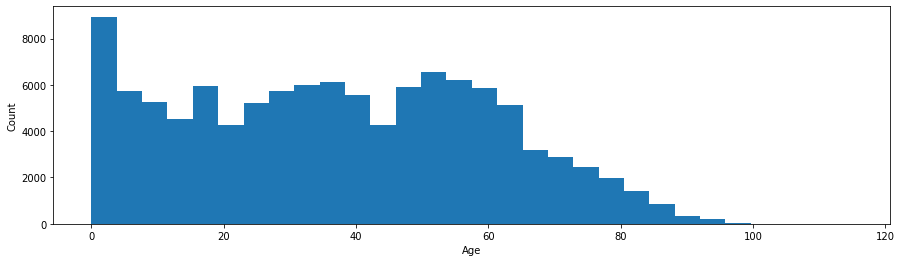

In [18]:
# Distribution of Age in the dataset
plt.figure(figsize= [15,4])
plt.hist(data = df, x='Age', bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

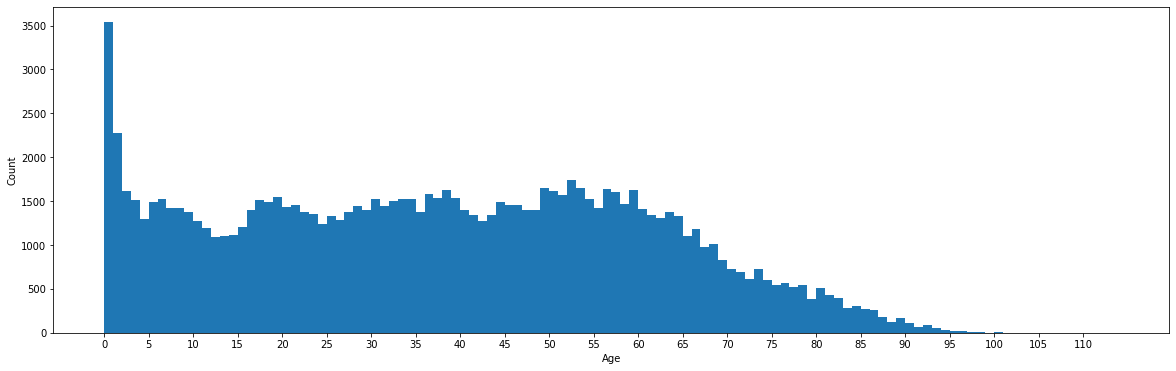

In [19]:
# Review with smaller bins 
fig, axes = plt.subplots(figsize= [20,6])
bins = np.arange(0, df.Age.max(),1)
xticks = np.arange(0, df.Age.max(), 5)
plt.hist(data = df, x='Age', bins = bins)
plt.xticks(xticks,xticks)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [20]:
pd.DataFrame(df['Age'].describe())

,Age
count,110526.000000
mean,37.089219
std,23.110026
min,0.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


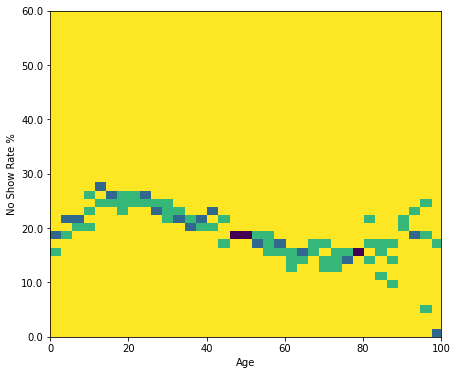

In [21]:
# Heatmap to review the relationship between Age vs No-show rate
age_noshow_df = pd.DataFrame(df.groupby('Age')['No_show'].mean()).reset_index()
plt.figure(figsize = [7,6])
plt.hist2d(data = age_noshow_df, x= 'Age', y = 'No_show', cmap ='viridis_r', bins =40)
plt.xlim(0,100)
plt.xlabel('Age')
ticks, label = plt.yticks()
plt.yticks(ticks,(100 * ticks).round())
plt.ylabel('No Show Rate %')
plt.show()

From the distribution and the stats table of Age, we can see that 50% of patient in this dataset are between age 18 - 55. Around 3500 patients are under Age 1, which is the largest single age group among all ages. From the heatmap, we can see there are some relationships between age and No Show Rate. The younger and the older the patients are, the lower the No Show Rate could be. If we want to predict the No Show rate, it would be interesting dive deeper into the relationship. 

###  Categorial variables

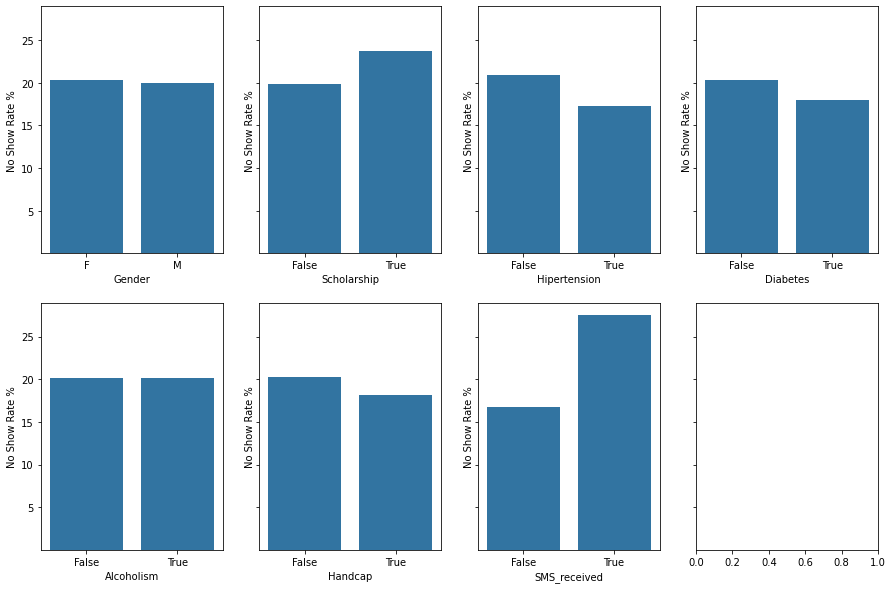

In [22]:
# No Show Rate vs Various Categorical Variables
base_color = sb.color_palette()[0]
cat_vars = ['Gender','Scholarship', 'Hipertension','Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
fig, ax = plt.subplots(2,4,figsize = [15,10], sharey=True)
ax = ax.flatten()
for var, i in zip(cat_vars, np.arange(0,8,1)):
    sb.barplot(data = df, x=var, y='No_show', color = base_color, ci=None, ax = ax[i])
    ax[i].set(ylabel='No Show Rate %')
    
plt.yticks([0.05,0.10,0.15,0.2,0.25],[5,10,15,20,25])
#plt.tight_layout()
plt.show()

- Gender doesn't seem to have relationship with the appointment show up rate.
- Patients who are in the welfare program also showed higher No Show Rate. 
- Patients with health pre-conditions, such as Diabetes, High blood pressure (Hipertension) and Handicap have lower No Show Rate. 
- Even though there is a setup of SMS reminder/confirmation in place, it doesn't seem to help to prevent patients from skipping the appointment. The No Show rate is higher for those who received the SMS text message. 

### Appointment Day

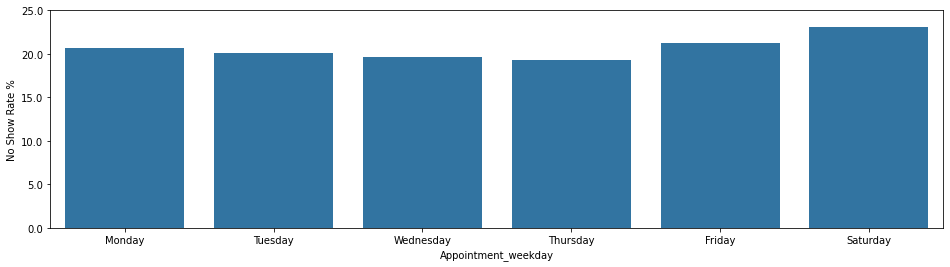

In [23]:
# No show rate in different Weekday
plt.figure(figsize = [16,4])
day_order = ['Monday', 'Tuesday','Wednesday', 'Thursday','Friday','Saturday']
sb.barplot(data = df, x = 'Appointment_weekday', y='No_show', order = day_order, color = base_color, ci=None)
ticks, label = plt.yticks()
plt.yticks(ticks,(100 * ticks).round())
plt.ylabel('No Show Rate %')
plt.show()

The appointments in the dataset are only from Monday to Saturday. We can see from the barplot above that the No Show Rate are slightly higher on Saturday than the Weekdays.

### Waiting Time

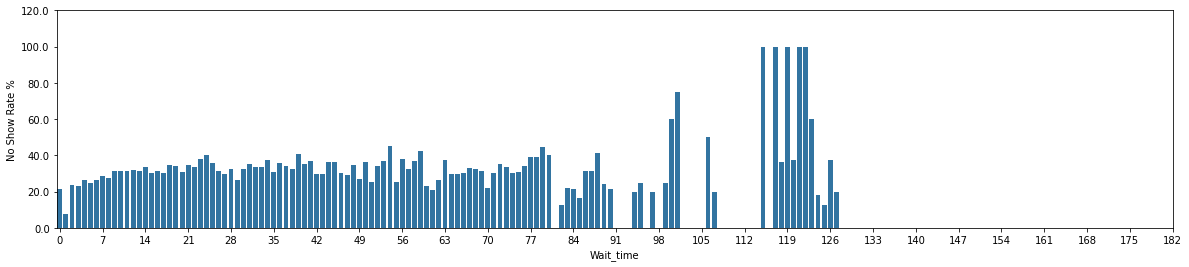

In [24]:
# Relationship between awaiting time and No Show Rate
plt.figure(figsize=[20,4])
ticks = np.arange(0,df['Wait_time'].max()+7,7)
sb.barplot(data = df, x = 'Wait_time', y = 'No_show', color = base_color, ci = None)
plt.xticks(ticks,ticks)
ticks, label = plt.yticks()
plt.yticks(ticks,(100 * ticks).round())
plt.ylabel('No Show Rate %')
plt.show()

In [25]:
pd.DataFrame(df['Wait_time'].describe())

,Wait_time
count,110526.000000
mean,9.881765
std,14.812434
min,0.000000
25%,1.000000
50%,3.000000
75%,14.000000
max,178.000000


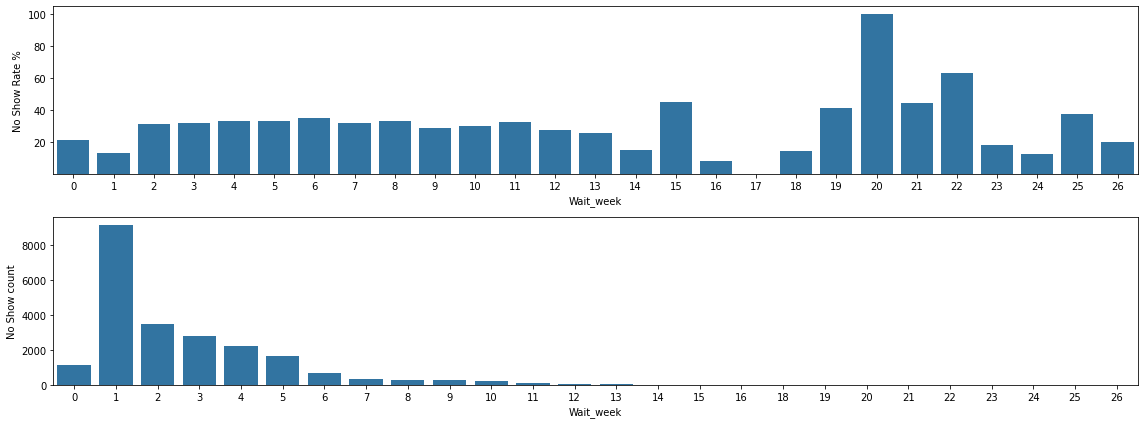

In [26]:
# Convert the measurement of awaiting time to week. Create a new column 'Wait_week'.
# Values in 'Wait_week' means the number of week between scheduled day and the appointment day.
# 0 means same day appointment. 1 means the wait time is between 0-1 week, 2 is 1-2 week, vise versa.
import math
df['Wait_week'] = [math.ceil(x) for x in df['Wait_time']/7]
fig, ax = plt.subplots(2, figsize = [16,6])

ax1 = sb.barplot(data=df, x='Wait_week', y='No_show', color = base_color, ci=None, ax = ax[0])
ax1.set(ylabel='No Show Rate %')
ax1.set_yticks([0.2,0.4,0.6,0.8,1])
ax1.set_yticklabels([20,40,60,80,100])


df_NoShow = df[df['No_show']==True]
ax2 = sb.countplot(data = df_NoShow, x='Wait_week', ax = ax[1], color = base_color)
ax2.set(ylabel='No Show count')

plt.tight_layout()
plt.show()

From the table and charts above, we can see that the minimum waiting time is 0 day and the max is 180 days with the average being around 10 days. The appointments that have less than 7 waiting days (less than a week) have lower No Show rate. 